In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from collections import Counter

def find_duplicate_rows(X):
    Z = X
    # 将数组中的每一行表示为元组，并将这些元组存储在列表中
    row_tuples = [tuple(row) for row in Z]

    # 使用Python的collections.Counter来计算元组的出现次数
    row_counts = Counter(row_tuples)

    # 初始化总的重复次数
    total_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 打印重复行的行号（索引）和它们的重复次数，并计算总的重复次数
    for index, row in enumerate(Z):
        row_tuple = tuple(row)
        if row_tuple not in counted_rows:
            count = row_counts[row_tuple]
            if count > 1:
                duplicate_indices = [i for i, r in enumerate(Z) if tuple(r) == row_tuple]
                print(f"行 {index} 重复了 {count} 次，与行 {duplicate_indices} 重复")
                total_duplicate_count += count
            counted_rows.add(row_tuple)  # 将该行添加到已计数的行集合中

    # 打印总的重复次数
    print(f"总的重复次数为: {total_duplicate_count}")

    # 初始化总的不同重复行数
    total_unique_duplicate_count = 0

    # 创建一个集合来存储已经计数过的行
    counted_rows = set()

    # 计算不同的重复行数
    for row_tuple, count in row_counts.items():
        if count > 1:
            total_unique_duplicate_count += 1
            counted_rows.add(row_tuple)

    # 打印总的不同重复行数
    print(f"总的不同重复行数为: {total_unique_duplicate_count}")

# 导入数据

In [3]:
import pandas as pd

folder_path = "original_data/"

df_s1 = pd.read_csv(folder_path + 'aryl-1.csv', encoding='utf-8', header=None)
df_s2 = pd.read_csv(folder_path + 'aryl-2.csv', encoding='utf-8', header=None)
df_s5 = pd.read_csv(folder_path + 'aryl-5.csv', encoding='utf-8', header=None)
df_s11 = pd.read_csv(folder_path + 'aryl-11.csv', encoding='utf-8', header=None)

In [4]:
print(df_s1.shape,df_s2.shape,df_s5.shape,df_s11.shape)

(264, 121) (264, 121) (264, 121) (264, 121)


# 数据合并

In [5]:
merged_df = pd.concat([df_s1, df_s2, df_s5, df_s11], axis=0)
print(merged_df.shape)

(1056, 121)


In [6]:
# 删除第20列到第46列   #去除芳香卤卤化物的描述符
columns_to_drop = merged_df.columns[19:45]  
merged_df = merged_df.drop(columns=columns_to_drop, axis=1)
print(merged_df.shape)

(1056, 95)


In [7]:
x_exp = merged_df.iloc[:, :-1].values  # 假设编号列是第0列，x列从第2列到倒数第二列
y_exp = merged_df.iloc[:, -1].values  # 最后一列作为y
print(x_exp.shape)
print(y_exp.shape)

(1056, 94)
(1056,)


# 对x进行minmax+pca+minmax

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

x_exp_mm = scaler.fit_transform(x_exp)

In [9]:
from sklearn.decomposition import PCA

def PCA_dim_select(selected_method, n_dims):
    if selected_method == 'auto':
        assert type(n_dims) == float
        selected_dim = n_dims
    elif selected_method == 'assigned':
        # assert type(n_dims) == int
        selected_dim = int(n_dims)
    return selected_dim

pca_dims = 0.95
pca = PCA(n_components=PCA_dim_select('auto', pca_dims))

x_exp_mm_pca = pca.fit_transform(x_exp_mm)
print(x_exp_mm_pca.shape)

(1056, 8)


In [10]:
scaler1 = MinMaxScaler()
x_exp_mm_pca_mm = scaler1.fit_transform(x_exp_mm_pca)

# 检查y是否需要处理

In [18]:
#去除存在nan的点
nan_indices = np.isnan(y_exp)
# X = X[~nan_indices.flatten()]
# Y = Y[~nan_indices.flatten()]

true_indices = np.where(nan_indices)[0]
print("True 的索引:", true_indices)

True 的索引: [317]


In [14]:
y_log = np.log(y_exp + 1e-10)

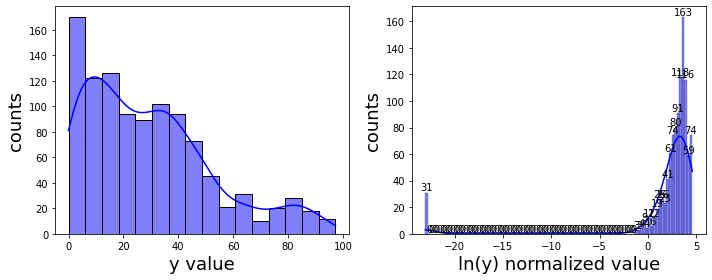

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(y_exp, kde=True, color='blue', ax=axes[0])
axes[0].set_xlabel('y value', fontsize=18)  
axes[0].set_ylabel('counts', fontsize=18)   

sns.histplot(y_log, kde=True, color='blue', ax=axes[1])
axes[1].set_xlabel('ln(y) normalized value', fontsize=18)  
axes[1].set_ylabel('counts', fontsize=18)  
axes[1].yaxis.set_major_locator(plt.MaxNLocator(integer=True))

heights = [p.get_height() for p in axes[1].patches]
for i, height in enumerate(heights):
    if height.is_integer():  
        axes[1].annotate(str(int(height)), (axes[1].patches[i].get_x() + axes[1].patches[i].get_width() / 2, height),
                         ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

# x与y合并为数据集

In [19]:
columns = [f'x{i+1}' for i in range(x_exp_mm_pca_mm.shape[1])]
x_df = pd.DataFrame(x_exp_mm_pca_mm, columns=columns)
y_df = pd.DataFrame(y_exp, columns=['y'])
merged_data = pd.concat([x_df, y_df], axis=1)
merged_data.to_excel('original_processed/merged_data.xlsx', index=False)

# 数据划分为原始大小

In [21]:
# 根据原来的大小划分数据
df_s1_cleaned = merged_data.iloc[:len(df_s1), :]
df_s2_cleaned = merged_data.iloc[len(df_s1):len(df_s1) + len(df_s2), :]
df_s5_cleaned = merged_data.iloc[len(df_s1) + len(df_s2):len(df_s1) + len(df_s2) + len(df_s5), :]
df_s11_cleaned = merged_data.iloc[len(df_s1) + len(df_s2) + len(df_s5):, :]

print(df_s1_cleaned.shape,df_s2_cleaned.shape,df_s5_cleaned.shape,df_s11_cleaned.shape)

# 指定保存路径
output_folder_path = "original_processed/"

# 保存为 Excel 文件
df_s1_cleaned.to_excel(output_folder_path + 'aryl-1.xlsx', index=False, header=False)
df_s2_cleaned.to_excel(output_folder_path + 'aryl-2.xlsx', index=False, header=False)
df_s5_cleaned.to_excel(output_folder_path + 'aryl-5.xlsx', index=False, header=False)
df_s11_cleaned.to_excel(output_folder_path + 'aryl-11.xlsx', index=False, header=False)

(264, 9) (264, 9) (264, 9) (264, 9)
